In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#ignore warning messages
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [ ]:
!git clone https://github.com/adobe/NLP-Cube.git

fatal: destination path 'NLP-Cube' already exists and is not an empty directory.


In [ ]:
!pip install -q tensorflow==2.3
#аугментации изображений
!pip install albumentations -q
!pip install ktrain
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru
!pip install -U nlpcube

Requirement already up-to-date: pymorphy2-dicts-ru in /usr/local/lib/python3.6/dist-packages (2.4.404381.4453942)
Requirement already up-to-date: nlpcube in /usr/local/lib/python3.6/dist-packages (0.1.0.8)


In [ ]:
!pip install catboost

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy #for some statistics
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p

import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from tqdm.notebook import tqdm

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#CV
import albumentations
from tensorflow.keras.applications.xception import Xception

#ktrain
import ktrain
from ktrain import tabular, text
from ktrain.data import TFDataset

#text preproccessing
import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from cube.api import Cube
import string
from wordcloud import WordCloud, STOPWORDS

# plt
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
#rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

In [ ]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/car_price_pred_min/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [ ]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Посмотрим на исходные данные, основные статистики, а также наличие пропусков в столбцах:

In [ ]:
train.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4280,седан,BMW,серый,ID: 38742\n«МБ Измайлово» – официальный диле...,2.0 LTR,136 N12,бензин,241251,2008,3ER,318i 2.0 AT (136 л.с.),4,"539,000.00",2011,1099684586,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5975,седан,AUDI,коричневый,Продаю свой авто в связи с крайне редким испол...,1.8 LTR,120 N12,бензин,55000,2011,A4,1.8 CVT (120 л.с.),4,"950,000.00",2014,1093102394,SEDAN VARIATOR 1.8,вариатор,2 владельца,NaN,Оригинал,передний,Левый
1452,внедорожник 5 дв.,AUDI,коричневый,"Автомобиль в идеальном состоянии не битый, не ...",2.0 LTR,225 N12,бензин,140135,2012,Q5,2.0 AT (225 л.с.) 4WD,5,"1,050,000.00",2013,1091088088,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2 владельца,1 год и 11 месяцев,Оригинал,полный,Левый


In [ ]:
def param_data(data):
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

print('Размер тренировочной выборки:', train.shape)
print('Размер валидационной выборки:', test.shape)
print('Первоначальная пропорция test/train:', round((test.shape[0]/train.shape[0]),2))

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'↓ Train ↓ {train.shape}', f'↓ Test ↓ {test.shape}'],  
          sort=False)

Размер тренировочной выборки: (6682, 22)
Размер валидационной выборки: (1671, 21)
Первоначальная пропорция test/train: 0.25


↓ Train ↓ (6682, 22)                \
                                   dtypes nunique  isna   
bodyType                           object      17     0   
brand                              object       3     0   
color                              object      16     0   
description                        object    6147     0   
engineDisplacement                 object      48     0   
enginePower                        object     146     0   
fuelType                           object       4     0   
mileage                             int64    2900     0   
modelDate                           int64      41     0   
model_info                         object     118     0   
name                               object     900     0   
numberOfDoors                       int64       4     0   
price                             float64    1628     0   
productionDate                      int64      38     0   
sell_id                             int64    6682     0   
vehicleConfiguration               object     288     0   
vehicleTransmission                object       4     0   
Владельцы                          object       3     1   
Владение                           object     173  4326   
ПТС                                object       2     0   
Привод                             object       3     0   
Руль                               object       2     0   

                                                                         \
                                                                 loc[0]   
bodyType                                                          седан   
brand                                                               BMW   
color                                                            чёрный   
description           Авто на бодром ходу.  Все работает отлично.  П...   
engineDisplacement                                              3.0 LTR   
enginePower                                                     272 N12   
fuelType                                                         бензин   
mileage                                                          245000   
modelDate                                                          2007   
model_info                                                          5ER   
name                                        530xi 3.0 AT (272 л.с.) 4WD   
numberOfDoors                                                         4   
price                                                        599,000.00   
productionDate                                                     2007   
sell_id                                                      1099980990   
vehicleConfiguration                                SEDAN AUTOMATIC 3.0   
vehicleTransmission                                      автоматическая   
Владельцы                                                   3 или более   
Владение                                                            NaN   
ПТС                                                            Оригинал   
Привод                                                           полный   
Руль                                                              Левый   

                     ↓ Test ↓ (1671, 21)                    \
                                  dtypes  nunique     isna   
bodyType                          object    14.00     0.00   
brand                             object     3.00     0.00   
color                             object    15.00     0.00   
description                       object 1,540.00     0.00   
engineDisplacement                object    43.00     0.00   
enginePower                       object   120.00     0.00   
fuelType                          object     4.00     0.00   
mileage                            int64   935.00     0.00   
modelDate                          int64    37.00     0.00   
model_info                        object   101.00     0.00   
name                              object   536.00     0.00 

In [ ]:
# Вспомогательная функция
# Helper func
def features_info(df):
    return pd.DataFrame({
        'dtypes': df.dtypes.values, 
        'nunique': df.nunique().values, 
        'isna': df.isna().sum().values, 
        'unique': {x: df[x].unique() for x in df}
    }, index = df.loc[0].index)

pd.set_option('max_colwidth', 80)

print('Размер тренировочной выборки:', train.shape)
print('Размер валидационной выборки:', test.shape)
print('Первоначальная пропорция test/train:', round((test.shape[0]/train.shape[0]),2))

pd.concat([features_info(train), 
           features_info(test)], 
          keys = ['↓ df_train ↓', '↓ df_test ↓'], 
          axis = 1, sort = False
         ).fillna('-')

Размер тренировочной выборки: (6682, 22)
Размер валидационной выборки: (1671, 21)
Первоначальная пропорция test/train: 0.25


↓ df_train ↓                \
                           dtypes nunique  isna   
bodyType                   object      17     0   
brand                      object       3     0   
color                      object      16     0   
description                object    6147     0   
engineDisplacement         object      48     0   
enginePower                object     146     0   
fuelType                   object       4     0   
mileage                     int64    2900     0   
modelDate                   int64      41     0   
model_info                 object     118     0   
name                       object     900     0   
numberOfDoors               int64       4     0   
price                     float64    1628     0   
productionDate              int64      38     0   
sell_id                     int64    6682     0   
vehicleConfiguration       object     288     0   
vehicleTransmission        object       4     0   
Владельцы                  object       3     1   
Владение                   object     173  4326   
ПТС                        object       2     0   
Привод                     object       3     0   
Руль                       object       2     0   

                                                                                                       \
                                                                                               unique   
bodyType              [седан, лифтбек, внедорожник 5 дв., хэтчбек 5 дв., минивэн, универсал 5 дв.,...   
brand                                                                           [BMW, AUDI, MERCEDES]   
color                 [чёрный, серебристый, белый, синий, серый, красный, коричневый, зелёный, гол...   
description           [Авто на бодром ходу.  Все работает отлично.  По электрике,ходовой.,АКПП ДВС...   
engineDisplacement    [3.0 LTR, 2.8 LTR, 3.5 LTR, 2.0 LTR, 1.8 LTR, 5.5 LTR, 2.5 LTR, 1.6 LTR, 1.5...   
enginePower           [272 N12, 204 N12, 306 N12, 180 N12, 160 N12, 184 N12, 197 N12, 326 N12, 190...   
fuelType                                                            [бензин, дизель, гибрид, электро]   
mileage               [245000, 183000, 122733, 151000, 140000, 229000, 50, 90000, 87000, 171644, 5...   
modelDate             [2007, 2011, 2009, 2006, 2016, 2015, 2014, 2005, 2013, 2008, 2002, 2017, 201...   
model_info            [5ER, A6, E_KLASSE, A5, C_KLASSE, 7ER, 3ER, X4, M_KLASSE, S_KLASSE_AMG, Q5, ...   
name                  [530xi 3.0 AT (272 л.с.) 4WD, 2.8 CVT (204 л.с.), 350 3.5 AT (306 л.с.) 4WD,...   
numberOfDoors                                                                            [4, 5, 2, 3]   
price                 [599000.0, 850000.0, 1325000.0, 815000.0, 810000.0, 550000.0, 3170000.0, 290...   
productionDate        [2007, 2011, 2013, 2020, 2016, 2015, 2014, 2017, 2008, 2009, 2006, 2012, 201...   
sell_id               [1099980990, 1095836906, 1100195530, 1099880662, 1083244610, 1049987852, 109...   
vehicleConfiguration  [SEDAN AUTOMATIC 3.0, SEDAN VARIATOR 2.8, SEDAN AUTOMATIC 3.5, SEDAN VARIATO...   
vehicleTransmission                        [автоматическая, вариатор, роботизированная, механическая]   
Владельцы                                                 [3 или более, 2 владельца, 1 владелец, nan]   
Владение              [nan, 8 лет и 6 месяцев, 4 года и 9 месяцев, 2 года и 9 месяцев, 6 лет и 9 м...   
ПТС                                                                              [Оригинал, Дубликат]   
Привод                                                                     [полный, передний, задний]   
Руль                                                                                  [Левый, Правый]   

                     ↓ df_test ↓                    \
                          dtypes  nunique     isna   
bodyType                  object    14.00     0.00   
brand                     object     3.00     0.00   
color                     object    15.00     0.00   
descr

Статистика показывает, что поля Владельцы и Владение содержат пропуски. Обработаем их далее, сейчас же посмотрим, как выглядят распределения числовых признаков:

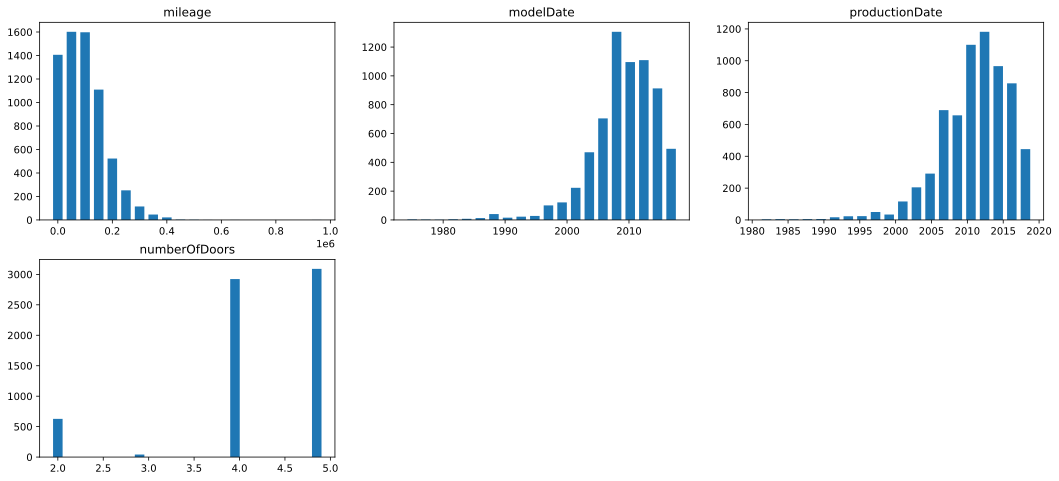

In [ ]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna(),
    'numberOfDoors': train['numberOfDoors'].dropna()
})

Числовые признаки имеют распределение, отличное от нормального. Проведем первичный анализ целевой переменной:

count        6,682.00
mean     1,899,868.12
std      1,914,153.12
min        301,301.00
25%        800,000.00
50%      1,300,000.00
75%      2,299,283.25
max     23,900,000.00
Name: price, dtype: float64

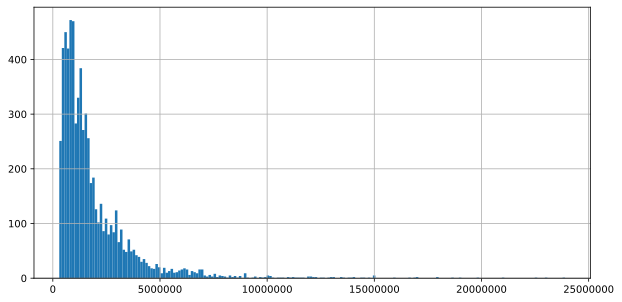

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
rcParams['figure.figsize'] = 10, 5
train.price.hist(bins=200).ticklabel_format(style='plain')
train.price.describe()

25-й перцентиль: 800000.0, 75-й перцентиль: 2299283.25, IQR: 1499283.25,  Границы выбросов: [-1448924.875, 4548208.125].


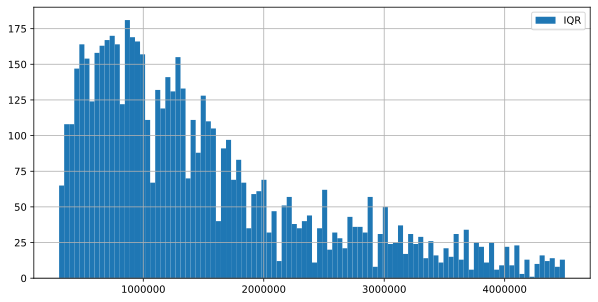

In [ ]:
median = train.price.median()
IQR = train.price.quantile(0.75) - train.price.quantile(0.25)
perc25 = train.price.quantile(0.25)
perc75 = train.price.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

rcParams['figure.figsize'] = 10, 5

train.price.loc[train.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 100, label = 'IQR').ticklabel_format(style='plain')
#plt.ax.ticklabel_format(useOffset=False)
plt.legend();

Как видно из статистик и графика, большинство цен распределены между 800к и 2,3М (медиана 1.9М, 25-й перцентиль 800к и 75-й — 2.3М). Данные несбалансированы, присутствуют выбросы (например, максимальное значение - почти 25М). Посмотрим внимательнее на price на предмет выбросов

Отфильтруем согласно получившимся статистикам данные:

In [ ]:
train = train.loc[train.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

print('Размер тренировочной выборки:', train.shape)
print('Текущая пропорция test/train:', round((test.shape[0]/train.shape[0]),2))

Размер тренировочной выборки: (6233, 22)
Текущая пропорция test/train: 0.27


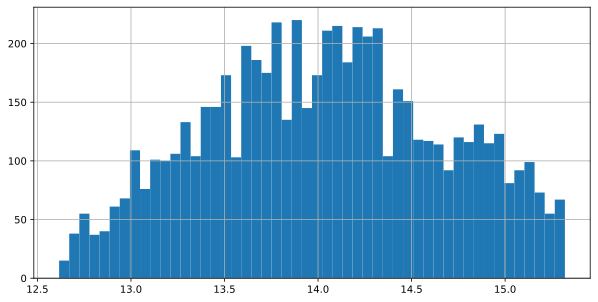

In [ ]:
rcParams['figure.figsize'] = 10, 5
np.log1p(train.price).hist(bins=50);

Применяю логарифмирование целевой переменной:

In [ ]:
train["price"] = np.log1p(train["price"])

# PreProc Tabular Data

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6233, 23) (1671, 23) (7904, 23)


Сгенерируем несколько новых фичей для признака Description

In [ ]:
#заполним пропуски
data['description'] = data['description'].fillna('Пустое объявление')

# Приведем текст описания к нижнему регистру
data['description'] = data['description'].apply(lambda x: x.lower())

#Добавим дополнительный признак - длина объявления 
data['description_len'] = data['description'].apply(lambda x: len(x.split()))

#sns.distplot(np.log1p(data.query('sample == 1')['description_len']));

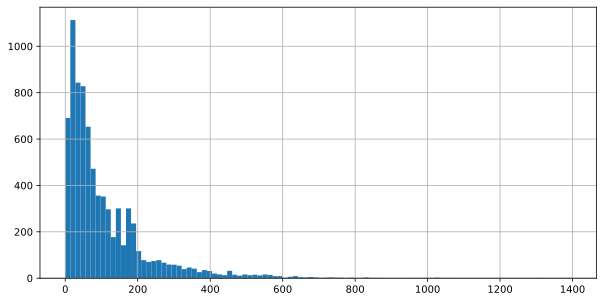

In [ ]:
#посмотрим на длину обьявлений
data['description_len'].hist(bins=100)

In [ ]:
#Посмотрим внимательнее на обьявления. Первичный анализ показал, что пропусков в данных нет, тем не менее, поле предположительно может содержать аномалии
data[data['description_len']<=1]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,description_len
159,минивэн,MERCEDES,серый,срочно!!!,3.0 LTR,224 N12,дизель,235000,2005,R_KLASSE,320 Long 3.0d AT (224 л.с.) 4WD,5,2006,1033486211,MINIVAN AUTOMATIC 3.0,автоматическая,3 или более,5 лет и 8 месяцев,Оригинал,полный,Левый,0,0.00,1
388,седан,MERCEDES,чёрный,,2.0 LTR,184 N12,бензин,119000,2014,C_KLASSE,200 2.0 AT (184 л.с.) 4WD,4,2017,1079099432,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,2 года и 10 месяцев,Оригинал,полный,Левый,0,0.00,0
813,купе,AUDI,чёрный,срочно!,1.8 LTR,170 N12,бензин,240000,2011,A5,1.8 CVT (170 л.с.),2,2012,1098040088,COUPE VARIATOR 1.8,вариатор,3 или более,5 лет и 3 месяца,Оригинал,передний,Левый,0,0.00,1
1005,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,Electro AT (126 кВт),5,2014,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.00,1
4083,внедорожник 5 дв.,BMW,серый,\n,3.0 LTR,231 N12,бензин,452968,1999,X5,3.0i 3.0 AT (231 л.с.) 4WD,5,2003,1100201362,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,13.02,0
5158,седан,MERCEDES,белый,[hfbocfb:15876],1.8 LTR,156 N12,бензин,106500,2006,C_KLASSE,180 BlueEFFICIENCY 1.8 AT (156 л.с.),4,2011,1099880072,SEDAN AUTOMATIC 1.8,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,1,13.37,1
5856,седан,BMW,белый,продаю,3.0 LTR,326 N12,бензин,130000,2008,7ER,740Li 3.0 AT (326 л.с.),4,2009,1098834714,SEDAN AUTOMATIC 3.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,1,13.91,1
6048,внедорожник 5 дв.,BMW,синий,.,4.4 LTR,555 N12,бензин,67700,2012,X6_M,4.4 AT (555 л.с.) 4WD,5,2013,1098368166,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,14.30,1
6337,минивэн,MERCEDES,чёрный,отличная,2.1 LTR,163 N12,дизель,44000,2014,V_KLASSE,220 d длинный 2.1d AT (163 л.с.) 4WD,5,2015,1100272278,MINIVAN AUTOMATIC 2.1,автоматическая,2 владельца,NaN,Оригинал,полный,Левый,1,14.90,1
7838,седан,BMW,серый,ц,2.0 LTR,190 N12,дизель,11,2016,5ER,520d 2.0d AT (190 л.с.),4,2020,1099600834,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,6 месяцев,Оригинал,задний,Левый,1,14.85,1


In [ ]:
data['description_len']=np.log1p(data['description_len'])

In [ ]:
#Добавим еще два признака на основе текста
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
text_feat = vectorizer.fit_transform(data['description'])
data['mean'] = text_feat.mean(axis = 1)
data['sum'] = text_feat.sum(axis = 1)

In [ ]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,description_len,mean,sum
1630,внедорожник 5 дв.,MERCEDES,белый,"автомобиль в отличном состоянии,полностью обслужен. документы оригинал. два ...",3.0 LTR,240 N12,дизель,134500,2011,M_KLASSE,350 CDI 3.0d AT (240 л.с.) 4WD,5,2011,1099440728,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2 владельца,2 года,Оригинал,полный,Левый,0,0.00,3.69,0.00,36
7801,внедорожник 5 дв.,BMW,серебристый,"хорошая, надежная машина на механике, стоит газовое оборудование, расход газ...",3.0 LTR,231 N12,бензин,444000,2003,X5,3.0i 3.0 MT (231 л.с.) 4WD,5,2003,1092804822,ALLROAD_5_DOORS MECHANICAL 3.0,механическая,3 или более,NaN,Оригинал,полный,Левый,1,13.12,3.14,0.00,23
638,седан,BMW,красный,внимание! только для клиентов avilon автомобили с пробегом мы предлагаем спе...,2.0 LTR,184 N12,бензин,85383,2011,3ER,320i xDrive 2.0 AT (184 л.с.) 4WD,4,2012,1099617426,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.00,4.98,0.00,127


In [ ]:
#добавлю признак из поля name
data['model_reference'] = data['name'].apply(lambda x: x.split()[0])

In [ ]:
#обрабатываю поле engineDisplacement
def engineDisplacement(row):
    engine = re.findall('\d\.\d', str(row))
    return float(engine[0]) if engine != [] else None

data['engineDisplacement'] = data['name'].apply(engineDisplacement)

In [ ]:
#напишем функцию, переводящую значения поля Владение в месяцы
def months_of_ownership(row):
    if pd.isnull(row): return
    s = row.replace('и', '').split()
    if len(s) == 2:
        return int(s[0]) * (1 if 'месяц' in s[1] else 12)
    else:
        return int(s[0]) * 12 + int(s[2])
    
data['Владение'] = data['Владение'].apply(months_of_ownership)

In [ ]:
#Заполним пропуски
data['Владение_is_none'] = pd.isna(data['Владение']).astype('uint8')
data['Владельцы'] = data['Владельцы'].fillna(3.0)
data['Владение'] = data['Владение'].fillna(data.query('sample == 1')['Владение'].median())

In [ ]:
#Добавляю признаки на основе временных характеристик
data['modelDate'] = 2020 - data['modelDate']
data['productionDate'] = 2020 - data['productionDate']
data['prod-model'] = data['productionDate'] - data['modelDate']

In [ ]:
#заготовка для ktrain
data_ktrain=data.copy()

Поработаем над полем Description:

In [ ]:
# Сконструируем dummy variables для признака 'description'

DESCRIPTION_PATTERN = {
    "leather"                 : "( 'темный' or 'тёмный' ) and 'салон'", 
    "carter"                  : "'защита' and 'картера'", 
    "ABS"                     : "'антиблокировочная' and 'система'", 
    "airbags"                 : "'подушки' and 'безопасности'", 
    "immob"                   : "'иммобилайзер'", 
    "central_locking"         : "'центральный' and 'замок'", 
    "on_board_computer"       : "'бортовой' and 'компьютер'", 
    "cruise_control"          : "'круиз-контроль' or 'круиз'", 
    "climat_control"          : "'климат-контроль' or 'климат'", 
    "multi_rudder"            : "'мультифункциональный' and 'руль'", 
    "power_steering"          : "( 'гидроусилитель' or 'гидро' or 'усилитель' ) and 'руля'", 
    "light_and_rain_sensors"  : "'датчики' and 'света' and 'дождя'", 
    "сarbon_body_kits"        : "'карбоновые' and 'обвесы'", 
    "rear_diffuser_rkp"       : "'задний' and 'диффузор'", 
    "door_closers"            : "'доводчики' and 'дверей'", 
    "rear_view_camera"        : "( 'камера' or 'видеокамера' ) and 'заднего' and 'вида'", 
    "amg"                     : "'amg'", 
    "bi_xenon_headlights"     : "( 'биксеноновые' or 'биксенон' ) and 'фары'", 
    "car_dealer"              : "'рольф' or 'панавто' or 'дилер' or 'кредит' or 'ликвидация'", 
    "alloy_wheels"            : "'легкосплавные' or 'колесные' or 'диски'", 
    "parking_sensors"         : "'парктроник' or 'парктронник'", 
    "dents"                   : "'вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина'", 
    "roof_with_panoramic_view": "'панорамная' and 'крыша'"
}

def compose_query(pattern):
    query = ''
    for w in pattern.split():
        query += w + (' ' if w in ['or', 'and', '(', ')'] else ' in x ')
    return eval(f'lambda x: {query}')

Queries = {f: compose_query(p) for f, p in DESCRIPTION_PATTERN.items()}

for feature in DESCRIPTION_PATTERN:
    data[feature] = data['description'].apply(
        lambda descr: int(Queries[feature](descr)))

После предварительной обработки признаков посмотрим на получившиеся статистики:

In [ ]:
features_info(data)

,dtypes,nunique,isna,unique
bodyType,object,17,0,"[универсал 5 дв., купе, седан, внедорожник 5 дв., родстер, лифтбек, хэтчбек ..."
brand,object,3,0,"[MERCEDES, BMW, AUDI]"
color,object,16,0,"[чёрный, белый, пурпурный, синий, коричневый, серый, зелёный, серебристый, к..."
description,object,7261,0,[всем привет!\n\nпродам эксклюзивный проект 124 универсал 300te-24 sportline...
engineDisplacement,float64,47,6,"[3.0, 2.5, 2.0, 3.5, 1.8, 2.2, 5.5, 4.8, 1.6, 4.7, 4.0, 1.5, 2.4, 1.4, 2.1, ..."
enginePower,object,150,0,"[220 N12, 313 N12, 218 N12, 136 N12, 190 N12, 340 N12, 245 N12, 316 N12, 170..."
fuelType,object,4,0,"[бензин, дизель, гибрид, электро]"
mileage,int64,3252,0,"[350000, 15000, 166600, 147000, 24000, 72000, 133615, 101000, 98294, 199254,..."
modelDate,int64,43,0,"[36, 9, 15, 4, 11, 12, 13, 31, 19, 14, 7, 6, 5, 16, 3, 2, 8, 17, 1, 10, 20, ..."
model_info,object,119,0,"[W124, 6ER, 3ER, 5ER, Q7, SL_KLASSE, A5, A4, GL_KLASSE, A6, 1ER, X5, X3, S_K..."


Изучив данные о признаках попробуем применить уменьшение размерности для высоковариативных признаков:
bodyType,color,enginePower,model_info
и удалим vehicleConfiguration как признак, содержащийся в других признаках, model_reference

In [ ]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color','enginePower', 'fuelType', 'model_info', 'name','vehicleConfiguration','vehicleTransmission', 'Владельцы','ПТС', 'Привод', 'Руль','model_reference']
#используем все числовые признаки
#numerical_features = ['engineDisplacement','mileage', 'modelDate','numberOfDoors', 'productionDate','Владение','description_len', 'mean', 'sum','Владение_is_none', 'prod-model']
numerical_features = ['engineDisplacement','mileage', 'modelDate','numberOfDoors', 'productionDate','Владение','description_len', 'leather', 'carter', 'ABS',
'airbags', 'immob', 'central_locking', 'on_board_computer',
       'cruise_control', 'climat_control', 'multi_rudder', 'power_steering',
       'light_and_rain_sensors', 'сarbon_body_kits', 'rear_diffuser_rkp',
       'door_closers', 'rear_view_camera', 'amg', 'bi_xenon_headlights',
       'car_dealer', 'alloy_wheels', 'parking_sensors', 'dents',
       'roof_with_panoramic_view', 'mean', 'sum','Владение_is_none', 'prod-model']

dummy_features = ['bodyType','color','enginePower','model_info']

# Model 2: CatBoostRegressor

Подготовим данные для обучения:

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    cats = list(set(categorical_features) - set(dummy_features))
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in cats:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    
    df_output = pd.get_dummies(df_output, columns=dummy_features, dummy_na=False)

    labelencoder = LabelEncoder()
    for feature in cats:
        df_output[feature] = labelencoder.fit_transform(df_output[feature])    
    
    # Нормализация данных
    #scaler = MinMaxScaler()
    
    scaler = RobustScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    for column in cats:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['mean','sum','name','vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [ ]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(6)

,brand,engineDisplacement,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,description_len,model_reference,Владение_is_none,prod-model,leather,carter,ABS,airbags,immob,central_locking,on_board_computer,cruise_control,climat_control,multi_rudder,power_steering,light_and_rain_sensors,сarbon_body_kits,rear_diffuser_rkp,door_closers,rear_view_camera,amg,bi_xenon_headlights,car_dealer,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_универсал 5 дв.,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 5 дв.,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,enginePower_100 N12,enginePower_101 N12,enginePower_102 N12,enginePower_105 N12,enginePower_109 N12,enginePower_110 N12,enginePower_113 N12,enginePower_114 N12,enginePower_115 N12,enginePower_116 N12,enginePower_118 N12,enginePower_120 N12,enginePower_122 N12,enginePower_125 N12,enginePower_129 N12,enginePower_130 N12,enginePower_132 N12,enginePower_133 N12,enginePower_136 N12,enginePower_140 N12,enginePower_143 N12,enginePower_150 N12,enginePower_156 N12,enginePower_160 N12,enginePower_163 N12,enginePower_165 N12,enginePower_166 N12,enginePower_170 N12,enginePower_174 N12,enginePower_177 N12,enginePower_180 N12,enginePower_184 N12,enginePower_190 N12,enginePower_192 N12,enginePower_193 N12,enginePower_194 N12,enginePower_197 N12,enginePower_200 N12,enginePower_204 N12,enginePower_210 N12,enginePower_211 N12,enginePower_215 N12,enginePower_218 N12,enginePower_220 N12,enginePower_223 N12,enginePower_224 N12,enginePower_225 N12,enginePower_230 N12,enginePower_231 N12,enginePower_233 N12,enginePower_234 N12,enginePower_235 N12,enginePower_238 N12,enginePower_239 N12,enginePower_240 N12,enginePower_242 N12,enginePower_245 N12,enginePower_249 N12,enginePower_250 N12,enginePower_252 N12,enginePower_255 N12,enginePower_256 N12,enginePower_258 N12,enginePower_260 N12,enginePower_264 N12,enginePower_265 N12,enginePower_269 N12,enginePower_270 N12,enginePower_271 N12,enginePower_272 N12,enginePower_279 N12,enginePower_280 N12,enginePower_286 N12,enginePower_290 N12,enginePower_292 N12,enginePower_296 N12,enginePower_299 N12,enginePower_300 N12,enginePower_306 N12,enginePower_310 N12,enginePower_313 N12,enginePower_316 N12,enginePower_320 N12,enginePower_321 N12,enginePower_326 N12,enginePower_329 N12,enginePower_333 N12,enginePower_335 N12,enginePower_340 N12,enginePower_347 N12,enginePower_350 N12,enginePower_354 N12,enginePower_355 N12,enginePower_360 N12,enginePower_367 N12,enginePower_370 N12,enginePower_372 N12,enginePower_381 N12,enginePower_388 N12,enginePower_390 N12,enginePower_394 N12,enginePower_400 N12,enginePower_401 N12,enginePower_402 N12,enginePower_407 N12,enginePower_408 N12,enginePower_420 N12,enginePower_421 N12,enginePower_422 N12,enginePower_431 N12,enginePower_435 N12,enginePower_445 N12,enginePower_450 N12,enginePower_455 N12,enginePower_457 N12,enginePower_462 N12,enginePower_469 N12,enginePower_476 N12,enginePower_487 N12,enginePower_500 N12,enginePower_507 N12,enginePower_510 N12,enginePower_514 N12,enginePower_517 N12,enginePower_520 N12,enginePower_525 N12,enginePower_530 N12,enginePower_544 N12,enginePower_550 N12,enginePower_555 N12,enginePower_557 N12,enginePower_558 N12,enginePower_560 N12,enginePower_571 N12,enginePower_575 N12,enginePower_580 N12,enginePower_585 N12,enginePower_591 N12,enginePower_605 N12,enginePower_609 N12,enginePower_610 N12,enginePower_612 N12,enginePower_625 N12,enginePower_626 N12,engin

#### Статистический анализ номинативных переменных
Проверим, есть ли статистическая разница в распределении цен по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цен автомобилей по различным параметрам неразличимы

In [ ]:
from itertools import combinations
from scipy.stats import ttest_ind

In [ ]:
def get_stat_dif(column):
    cols = train.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(train.loc[train.loc[:, column] == comb[0], 'price'], 
                        train.loc[train.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [ ]:
#for col in categorical_features:
#    get_stat_dif(col)
#df_preproc.drop(['model_reference','Руль'], axis = 1, inplace=True)

In [ ]:
#UPD статистический анализ не дал улучшения в метрике

#### Split data

In [ ]:
# Выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
#Разобьем тренировочные данные на трейн и тест для обучения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

### 2.1 Simple Catboost

In [ ]:
model = CatBoostRegressor(iterations = 7000,
                          #depth=12,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test,y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.018787
0:	learn: 0.0370721	test: 0.0371003	best: 0.0371003 (0)	total: 51.4ms	remaining: 5m 59s
500:	learn: 0.0090031	test: 0.0097970	best: 0.0097970 (500)	total: 2.3s	remaining: 29.9s
1000:	learn: 0.0078430	test: 0.0089544	best: 0.0089544 (1000)	total: 4.47s	remaining: 26.8s
1500:	learn: 0.0072132	test: 0.0085672	best: 0.0085671 (1499)	total: 6.64s	remaining: 24.3s
2000:	learn: 0.0067323	test: 0.0083161	best: 0.0083159 (1996)	total: 8.78s	remaining: 21.9s
2500:	learn: 0.0063581	test: 0.0081637	best: 0.0081636 (2498)	total: 11s	remaining: 19.7s
3000:	learn: 0.0060288	test: 0.0080631	best: 0.0080631 (2996)	total: 13.1s	remaining: 17.5s
3500:	learn: 0.0057410	test: 0.0080126	best: 0.0080106 (3490)	total: 15.3s	remaining: 15.3s
4000:	learn: 0.0054914	test: 0.0079696	best: 0.0079696 (3999)	total: 17.5s	remaining: 13.1s
4500:	learn: 0.0052742	test: 0.0079379	best: 0.0079379 (4500)	total: 19.7s	remaining: 10.9s
5000:	learn: 0.0050812	test: 0.0079233	best: 0.0079233 (500

In [ ]:
#Без логарифмирования целевой переменной катбуст дает метрику TEST mape: 11.9981%
#test_predict_catboost = model.predict(X_test)
#print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.4f}%")

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test),np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.04%


После подбора числа итераций даже на дефолтном lr Catboost дает неплохой результат в 11.04%. Ниже попробую его слегка улучшить, введя кросс-валидацию

In [ ]:
#подготавливаю файл для сабмита
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

In [ ]:
used_columns = ['productionDate',
 'modelDate',
 'enginePower',
 'mileage',
 'engineDisplacement',
 'model_info',
 'model_reference',
 'fuelType',
 'bodyType',
 'vehicleConfiguration',
 'description_len',
 'Привод',
 'prod-model',
 'Владельцы',
 'numberOfDoors',
 'brand',
 'Владение',
 'vehicleTransmission',
 'color',
 'ПТС',
 'amg',
 'car_dealer',
 'alloy_wheels']

In [ ]:
#X_train = X_train[used_columns]
#X_test = X_test[used_columns]
#X_sub = X_sub[used_columns]

### 2.2. Catboost Cross-Validation

In [ ]:
N_FOLDS=7

def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(
                        iterations = 10000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
    model.fit(X_train, y_train,
         eval_set=(X_test,y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )
    

    return(model)

submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(np.exp(y_test), np.exp(test_predict))
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(np.exp(y_test), np.exp(test_predict)):0.5f}")
    
    #feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    #print(feat_importances.nlargest(15).sort_values())
    # submissions
    submissions[f'sub_{idx+1}'] = np.exp(model.predict(X_sub))
    #model.save_model(f'catboost_fold_{idx+1}.model')


Learning rate set to 0.015067
0:	learn: 0.0371651	test: 0.0373045	best: 0.0373045 (0)	total: 5.29ms	remaining: 52.9s
500:	learn: 0.0093689	test: 0.0100608	best: 0.0100608 (500)	total: 2.27s	remaining: 43.1s
1000:	learn: 0.0082483	test: 0.0091913	best: 0.0091913 (1000)	total: 4.41s	remaining: 39.7s
1500:	learn: 0.0075707	test: 0.0087485	best: 0.0087485 (1500)	total: 6.61s	remaining: 37.4s
2000:	learn: 0.0071248	test: 0.0085036	best: 0.0085036 (2000)	total: 8.79s	remaining: 35.1s
2500:	learn: 0.0067608	test: 0.0083156	best: 0.0083153 (2498)	total: 11s	remaining: 33s
3000:	learn: 0.0064407	test: 0.0081912	best: 0.0081910 (2999)	total: 13.3s	remaining: 30.9s
3500:	learn: 0.0061724	test: 0.0081013	best: 0.0081013 (3500)	total: 15.4s	remaining: 28.7s
4000:	learn: 0.0059308	test: 0.0080450	best: 0.0080449 (3995)	total: 17.6s	remaining: 26.5s
4500:	learn: 0.0057302	test: 0.0080060	best: 0.0080060 (4500)	total: 19.8s	remaining: 24.2s
5000:	learn: 0.0055342	test: 0.0079723	best: 0.0079723 (5000)

In [ ]:
print(f'Mean Score: {np.mean(score_ls)*100:0.3f}%')
print(f'Std Score: {np.std(score_ls)*100:0.3f}%')
print(f'Max Score: {np.max(score_ls)*100:0.3f}%')
print(f'Min Score: {np.min(score_ls)*100:0.3f}%')

Mean Score: 10.787%
Std Score: 0.368%
Max Score: 11.415%
Min Score: 10.362%


Обучение на 7 фолдах дало прирост в mape c 11.04 до 10.787%.

In [ ]:
submissions.head()

,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7
0,"852,283.55","750,304.03","663,815.16","791,902.94","677,399.44","635,609.21","801,943.26"
1,"2,844,332.00","2,823,678.68","2,769,155.43","2,772,437.25","2,700,944.65","2,720,995.87","2,784,630.96"
2,"687,830.31","646,041.57","657,950.08","673,318.40","668,474.40","666,909.29","650,875.83"
3,"449,342.12","454,467.49","464,147.96","469,147.74","462,462.31","457,788.55","459,069.40"
4,"2,726,621.26","2,659,172.44","2,694,979.87","2,705,817.95","2,679,812.52","2,675,052.78","2,693,199.63"


In [ ]:
#формирую файл для сабмита
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_catboost_.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1099427284,"739,036.80"
1,1096405886,"2,773,739.26"
2,1100195294,"664,485.70"
3,1099827282,"459,489.37"
4,1100076198,"2,690,665.21"
5,1090159352,"3,153,683.25"
6,1098987386,"1,538,238.63"
7,1098639040,"1,535,921.23"
8,1099933039,"1,019,076.40"
9,1099565572,"485,567.33"


### 2.3. Feature Selection

In [ ]:
# feature importance
feature_importance = pd.Series(model.feature_importances_,index=X_train.columns).fillna(0).sort_values(ascending=False)
feature_importance

productionDate              25.29
engineDisplacement          18.56
modelDate                   18.47
mileage                      9.91
model_reference              5.16
                             ... 
enginePower_639 N12          0.00
enginePower_700 N12          0.00
enginePower_132 N12          0.00
model_info_SLC_KLASSE_AMG    0.00
enginePower_270 N12          0.00
Length: 342, dtype: float64

In [ ]:
# remove unimportant features
best_features = feature_importance.nlargest(23)
# select features
used_columns = best_features.index.tolist()
used_columns

['productionDate',
 'engineDisplacement',
 'modelDate',
 'mileage',
 'model_reference',
 'Привод',
 'fuelType',
 'model_info_G_KLASSE',
 'description_len',
 'bodyType_седан',
 'numberOfDoors',
 'prod-model',
 'Владельцы',
 'brand',
 'Владение',
 'bodyType_хэтчбек 5 дв.',
 'vehicleTransmission',
 'model_info_X1',
 'bodyType_внедорожник 5 дв.',
 'model_info_V_KLASSE',
 'model_info_E_KLASSE',
 'model_info_S_KLASSE',
 'bodyType_минивэн']

UPD. После ряда экспериментов отказалась от идеи использовать при обучении отобранные фичи,так как качество ухудшалось

In [ ]:
#X_train = X_train[used_columns]
#X_test = X_test[used_columns]
#X_sub = X_sub[used_columns]

In [ ]:
#model.fit(X_train, y_train,
#         eval_set=(X_test,y_test),
#         verbose_eval=100,
#         use_best_model=True,
#         #plot=True
#         )

In [ ]:
#test_predict_catboost = model.predict(X_test)
#print(f"TEST mape: {(mape(np.exp(y_test),np.exp(test_predict_catboost)))*100:0.2f}%")

# Model 3: Tabular NN
Цель данного блока - понять, какой результат может быть получен на табличных данных, если вместо классического ML-алгоритма применить нейронную сеть

### 3.1. Simple Dense NN

Построим обычную сеть:

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid")) #активация sigmoid вместо relu
model.add(L.Dropout(0.55)) #Подобраны параметры Dropout
model.add(L.BatchNormalization()) #добавила нормализацию
model.add(L.Dense(256, activation="sigmoid")) #активация sigmoid вместо relu
model.add(L.Dropout(0.55)) #Подобраны параметры Dropout
model.add(L.BatchNormalization()) #добавила нормализацию
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               175616    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [ ]:
#Добавляю условия на lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.01)

In [ ]:
# Compile model
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
#Указываю коллбэки
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=80, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
#Обучаем модель
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")
#print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.20%


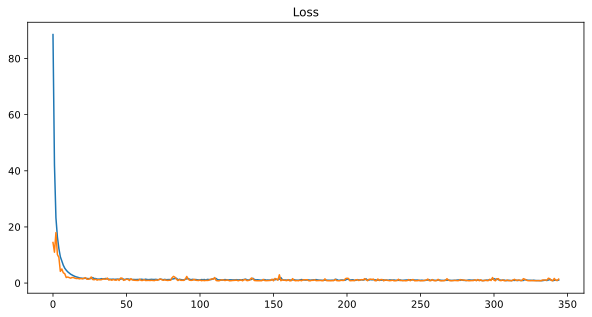

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

Простая NN дает порядка 11% mape на тесте для логарифмированной целевой переменной. Добавление нормализации и подбор параметров для регуляризации Dropout позволили улучшить первоначальную метрику в 14.24%. Однако, судя по графику обучения,имеет смысл посвятить больше времени подбору параметров регуляризации 

In [ ]:
#сохраняю модель
#model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_1.hdf5')

In [ ]:
#подготавливаю файл для сабмита
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_nn1[:,0])
sample_submission.to_csv('nn1_submission.csv', index=False)

In [ ]:
#Делаю бленд CV catboost и Dense NN для сабмита 12.46343 on LB
sub_predict_nn1=np.exp(sub_predict_nn1)
blend_sub_predict=(submissions['blend'].values +sub_predict_nn1[:,0])/2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_catboost_nn1_submission.csv', index=False)

### 3.2. Ktrain Tabular
В качестве альтернативы полносвязной сети для табличных данных был также опробован алгоритм ktrain. Подбор параметров для алгоритма только ухудшал метрику, так что было принято решение отказаться от этой идеи.

https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-08-tabular_classification_and_regression.ipynb

https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A4-customdata-text_regression_with_extra_regressors.ipynb

# Model 4: NLP + Multiple Inputs

Справочная информация:
https://habr.com/ru/post/517410/


### 4.0 Text Preprocessing
Посмотрим внимательнее на поле Description

In [ ]:
data.description

0       всем привет!\n\nпродам эксклюзивный проект 124 универсал 300te-24 sportline\...
1       продаю любимейшую тачилу.. обвес и тюнинг hamman. потому что совсем на ней н...
2       машина тут продаётся не в первый раз, но! только что:\n перебран двигатель с...
3       автомобиль в отличном состоянии, весь в родной краске ( красился бампер и кр...
4       немка! с бесключивым доступом и камерой заднего вида.\nавтомобиль в пленке s...
                                             ...                                       
7899    продаётся любимый автомобиль! за годы эксплуатация машина вела себя просто в...
7900    куплена у официального дилера в 2017 г. \n\nтретий владелец, все владельцы -...
7901    торг на месте. все работает. сборка немецкая. резина летняя новая на дисках....
7902    автомобиль в отличном состоянии.\n3-из авто в семье , обслуживание в профиль...
7903    удлиненный заводской pullman на базе w140 (вообще-то правильно заводской инд...
Name: description, Length: 7904,

In [ ]:
#сформируем словарь стоп-слов для очистки признака
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Определим функцию для очисти полей с описанием от знаков пунктуации и цифр
def text_prep(x):
    spec_chars = string.punctuation + '\xa0«»\t—…•–0123456789☛✅·☑️⭐🔥❤' #убираю доп.символы
    x = "".join([ch for ch in x if ch not in string.digits]) #убираю числа
    x = ' '.join(x.split()) #убираю символы переноса строки
    x = ' '.join([word for word in x.split() if word not in (stopwords.words('russian'))]) #очищаю строки от стоп-слов
    x = "".join([ch for ch in x if ch not in spec_chars])
    return x

#Применяю функцию
data['description']=data['description'].apply(text_prep)

In [ ]:
#t =data['description'][0:10]
#t

#### Lemmatizer

После первичной очистки текстовых полей, как правило, дальнейший анализ включает в себя лемматизацию.

https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

Для этого воспользуемся open-source фреймворком NLP-Cube:

https://github.com/adobe/NLP-Cube

In [ ]:
cube=Cube(verbose=True)

cube.load("ru")

Latest version found online: ru-1.1
Download complete, decompressing files ...                                         
Model extracted successfully.
Checking for associated vector embeddings file [wiki.dummy.vec] ...
Embeddings downloaded successfully.                                                  
	Loading embeddings ... 
	Loading tokenization model ...
	Loading lemmatization model ...
	Loading tagger model ...
	Loading parser model ...
Model loading complete.



In [ ]:
#Определим функцию, которая проводит лемматизацию для строк из description 
def text_lemmas(text):
    sentences=cube(text)
    lemmas = ""
    try:
        for entry in sentences[0]: # note we selected the first sentence (sentence[0])
            lemmas += entry.lemma
            # now, we look for a space after the lemma to add it as well
            if not "SpaceAfter=No" in entry.space_after:
                lemmas += " "
    except IndexError:
        lemmas = ""
    return lemmas

#data['description']=data['description'].apply(text_lemmas)

In [ ]:
%%time
text_lemmas(data.description[100])

CPU times: user 32.9 s, sys: 711 ms, total: 33.6 s
Wall time: 33.5 s


'автомобиль mercedesbenz внутренний парк небольшой пробег подробность уточнять отдел продажа ваш внимание представляться автомобиль mercedesbenz cкласс amg год пробег преимущество покупка автомобиль официальный дилер мерседесбенц руса очевидный это гарантия юридический чистота сделка проверить история автомобиль разнообразие форма оплата автомобиль наиболее привлекательный предложение кредитование приобретение лизинга возможность ряд случай приобретение сервисный сертификат автомобиль провести предпродажный подготовка приобретить автомобиль наш дилерский центр наслаждать управление ваш mercedesbenz cкласс amg каждый день автомобиль мерседесбенц корпоративный парк небольшой пробег подробность уточнять отдел продажа ваш внимание представляться автомобиль mercedesbenz cкласс amg год пробег преимущество покупка автомобиль официальный дилер мерседесбенц руса очевидный это гарантия юридический чистота сделка проверить история автомобиль разнообразие форма оплата автомобиль наиболее привлекат

Проведение лемматизации займет значительное время, судя по оценке времени обработки одной строки в датасете, так что в рамках данного кернела проводить ее не будем

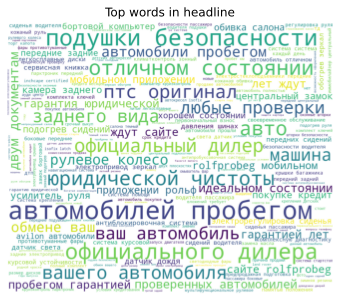

In [ ]:
#Посмотрим в целом на содержание получившегося очищенного признака description
text = ' '.join(data['description'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

### Tokenizer

In [ ]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]


In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
#data.description=data_ktrain.description

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.08 s, sys: 3.04 ms, total: 1.09 s
Wall time: 1.09 s


In [ ]:
print('Found %s unique tokens. ' % len(tokenize.word_index))

Found 37782 unique tokens. 


In [ ]:
#Визуально проверяем получившиеся токены
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'автомобиля': 3,
 'пробегом': 4,
 'состоянии': 5,
 'авто': 6,
 'салон': 7,
 'машина': 8,
 'автомобилей': 9,
 'птс': 10,
 'безопасности': 11,
 'сидений': 12,
 'автомобили': 13,
 'комплектация': 14,
 'года': 15,
 'комплект': 16,
 'bmw': 17,
 'пробег': 18,
 'кредит': 19,
 'дилера': 20,
 'sa': 21,
 'пакет': 22,
 'лет': 23,
 'водителя': 24,
 'км': 25,
 'диски': 26,
 'фары': 27,
 'сиденья': 28,
 'передние': 29,
 'руля': 30,
 'салона': 31,
 'датчик': 32,
 'оригинал': 33,
 'подушки': 34,
 'пассажира': 35,
 'отличном': 36,
 'дтп': 37,
 'состояние': 38,
 'торг': 39,
 'обслуживание': 40,
 'условия': 41,
 'зеркал': 42,
 '∙': 43,
 'официального': 44,
 'рольф': 45,
 'заднего': 46,
 'обогрев': 47,
 'подогрев': 48,
 'вашего': 49,
 'ваш': 50,
 'покупке': 51,
 'обмен': 52,
 'владелец': 53,
 'задний': 54,
 'полностью': 55,
 'продаю': 56,
 'официальный': 57,
 'комплекта': 58,
 'задние': 59,
 'замена': 60,
 'обмене': 61,
 'гарантия': 62,
 'электропривод': 63,
 'очень': 64,

In [ ]:
%%time
#Преобразуем получившиеся последовательности в 2d массив
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5343, 256) (890, 256) (1671, 256)
CPU times: user 953 ms, sys: 34 µs, total: 953 ms
Wall time: 957 ms


In [ ]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])
print(text_train_sequences[6].shape)

идеальное состояние салона кузова требует вложений родной пробег срок обслуживался каждые км нареканий автомобилю нет сборка  германия
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   

### 4.1 RNN NLP Model

Первоначально предложенные архитектуры сетей не содержали в себе регуляризацию, которая позволяет бороться с переобучением. Было решено оставить первоначальные варианты архитектур и добавить дополнительно слои Dropout и BatchNormalization, проведя эксперименты с число нейронов в Dense - слоях

NLP Part:

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.6))
model_nlp.add(L.BatchNormalization()) #Добавлено 
model_nlp.add(L.LSTM(128,)) 
model_nlp.add(L.Dropout(0.3))
model_nlp.add(L.BatchNormalization()) #Добавлено 
model_nlp.add(L.Dense(64, activation="sigmoid"))#активация sigmoid вместо relu
#model_nlp.add(L.Dropout(0.5)) #добавлена

MLP Part:

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))#активация sigmoid вместо relu
model_mlp.add(L.Dropout(0.55)) #Подобраны параметры Dropout
model_mlp.add(L.BatchNormalization()) #добавила нормализацию
model_mlp.add(L.Dense(256, activation="sigmoid")) #активация sigmoid вместо relu
model_mlp.add(L.Dropout(0.55)) #Подобраны параметры Dropout
model_mlp.add(L.BatchNormalization()) #добавила нормализацию


In [ ]:
#Multiple Inputs NN
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
#Добавляю условия на lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#после экспериментов с оптимизатором было решено от него все же отказаться, так как не было выявлено какого-либо прироста по метрике

#optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
#компилирую модель
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
#формирую чекпойнты
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
#обучаю
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 8s 687ms/step - loss: 36.4046 - MAPE: 36.4046 - val_loss: 19.3016 - val_MAPE: 19.3016
Epoch 2/500
11/11 [==============================] - 6s 553ms/step - loss: 12.7909 - MAPE: 12.7909 - val_loss: 25.5181 - val_MAPE: 25.5181
Epoch 3/500
11/11 [==============================] - 6s 562ms/step - loss: 10.3387 - MAPE: 10.3387 - val_loss: 9.2639 - val_MAPE: 9.2639
Epoch 4/500
11/11 [==============================] - 6s 563ms/step - loss: 5.8927 - MAPE: 5.8927 - val_loss: 8.6795 - val_MAPE: 8.6795
Epoch 5/500
11/11 [==============================] - 6s 558ms/step - loss: 4.5997 - MAPE: 4.5997 - val_loss: 3.5335 - val_MAPE: 3.5335
Epoch 6/500
11/11 [==============================] - 6s 559ms/step - loss: 4.1795 - MAPE: 4.1795 - val_loss: 7.8006 - val_MAPE: 7.8006
Epoch 7/500
11/11 [==============================] - 6s 559ms/step - loss: 3.4189 - MAPE: 3.4189 - val_loss: 2.2406 - val_MAPE: 2.2406
Epoch 8/500
11/11 [==========================

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn2[:,0])))*100:0.2f}%")

TEST mape: 11.11%


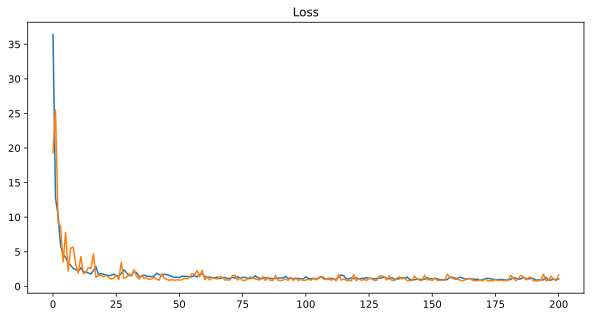

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

Значение метрики увеличено с14.23% до 11.11% за счет введения нормализации, смены функции активации и подбора LR. 
Тем не менее, судя по графику, имеет смысл продолжить эксперименты с регуляризацией, чтобы добиться более гладкой кривой функции.

In [ ]:
#сохраняю модель
#model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_mlp_nlp.hdf5')
model.save('nn_mlp_nlp.hdf5')

In [ ]:
#подготавливаю файл для сабмита
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_nn2[:,0])
sample_submission.to_csv('nn2_submission.csv', index=False)

Также во время работы над данным пунктом были проведены экперименты с ktrain, что не дало улучшения метрики

# Model 5: Image Data

### 5.1. Data

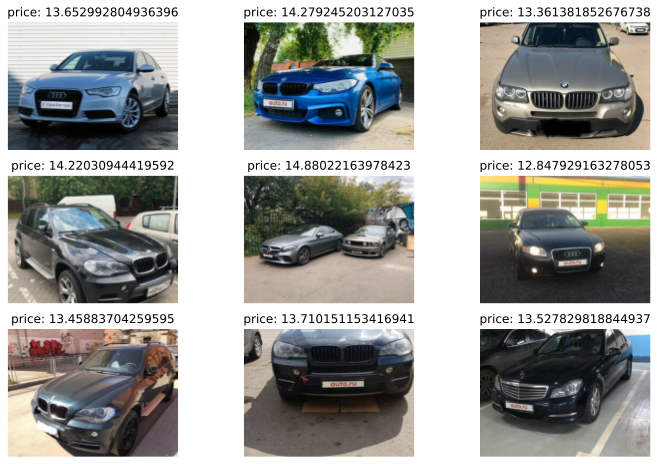

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5343, 240, 320, 3) dtype uint8
images shape (890, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### 5.2. Аугментация данных

Попробуем 3 подготовленных набора функций для аугментации изображений на базе библиотеки albumentations и визуально отберем лучшую

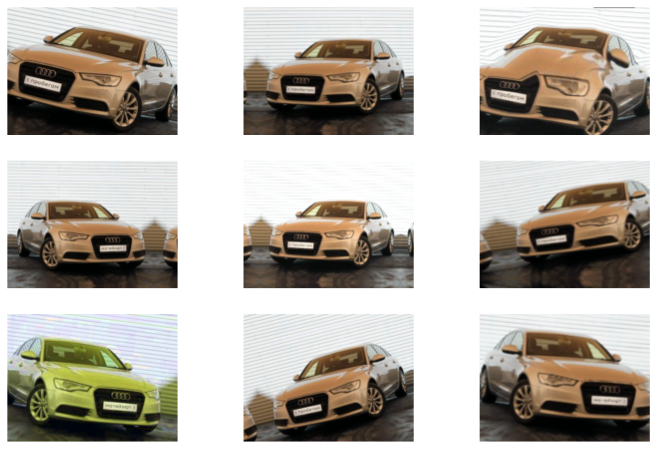

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Rotate,RandomBrightness,JpegCompression,
     RandomContrast
)


#https://albumentations.readthedocs.io/en/latest/examples.html
augmentation_1 = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation_1(image = images_train[1])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

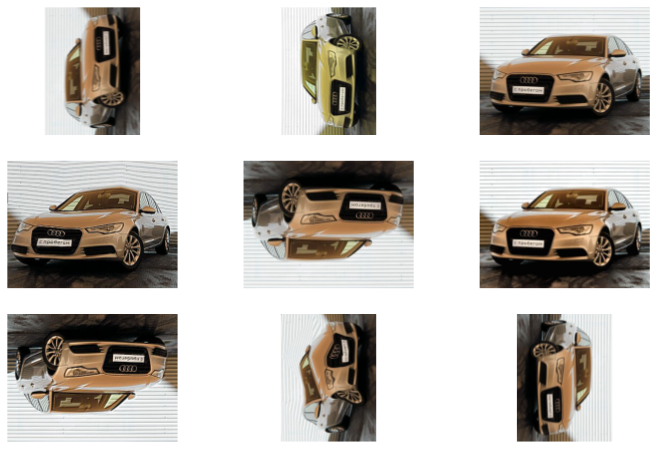

In [ ]:
#https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example.ipynb
augmentation_2 = Compose([
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
        Flip(),
        Transpose(),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=10, p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation_2 (image = images_train[1])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

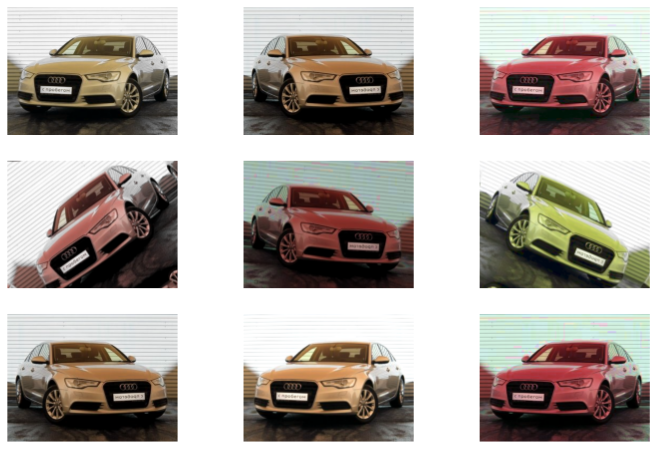

In [ ]:
#https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/tensorflow-example.ipynb
augmentation_3 = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation_3(image = images_train[1])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

После экспериментов с аугментациями было решено остановиться на варианте augmentation_1 как дающем наилучшее значении целевой метрики

In [ ]:
#Функция для применения аугментаций
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation_1(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
#Подготавливаю комбинированные датасеты для обучения multi-input сети
def process_image(image):
    return augmentation_1(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


#готолю датасеты для обучения

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

Загружаем предобученную сеть для анализа изображений без "головы":

In [ ]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
#efficientnet_model = Xception(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
#efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
#efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB5(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


В ходе работы над кернелом были опробованы 3 архитектуры сетей: EfficientNetB3, EfficientNetB0 (меньшее число параметров, что могло бы дать потенциальный выирыш в скорости обучения) и Xception - одна из SOTA-моделей по качеству для задач анализа изображений

СОБИРАЮ ВСЕ 3 МОДЕЛИ ВМЕСТЕ:

In [ ]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),
    L.Dropout(0.55),
    L.BatchNormalization(),
    L.Dense(256, activation = 'sigmoid'),
    L.Dropout(0.55),
    L.BatchNormalization(),
    ])


In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.6), #подобран параметр
    L.BatchNormalization(), #добавлено
    L.LSTM(128),
    L.Dropout(0.3), 
    L.BatchNormalization(),#добавлено
    L.Dense(64, activation="sigmoid"),#активация sigmoid вместо relu
    ])

In [ ]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])


# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(128, activation="relu")(head) #добавила еще один сверточный слой, чтобы сети было проще получать признаки из картинок
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)

In [ ]:
#model.summary()

In [ ]:
#добавляю политику на LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(0.005)

#компилирую модель
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=500,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/500
179/179 [==============================] - 320s 2s/step - loss: 10.0754 - MAPE: 10.0754 - val_loss: 1.6770 - val_MAPE: 1.6770
Epoch 2/500
179/179 [==============================] - 315s 2s/step - loss: 4.0342 - MAPE: 4.0342 - val_loss: 5.5310 - val_MAPE: 5.5310
Epoch 3/500
179/179 [==============================] - 315s 2s/step - loss: 3.6992 - MAPE: 3.6992 - val_loss: 5.0441 - val_MAPE: 5.0441
Epoch 4/500
179/179 [==============================] - 315s 2s/step - loss: 3.4713 - MAPE: 3.4713 - val_loss: 16.0021 - val_MAPE: 16.0021
Epoch 5/500
179/179 [==============================] - 314s 2s/step - loss: 2.8287 - MAPE: 2.8287 - val_loss: 13.9400 - val_MAPE: 13.9400
Epoch 6/500
179/179 [==============================] - 315s 2s/step - loss: 2.7160 - MAPE: 2.7160 - val_loss: 3.5015 - val_MAPE: 3.5015
Epoch 7/500
179/179 [==============================] - 314s 2s/step - loss: 2.6612 - MAPE: 2.6612 - val_loss: 5.4774 - val_MAPE: 5.4774
Epoch 8/500
179/179 [=====================

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn3[:,0])))*100:0.2f}%")

TEST mape: 13.23%


Удалось снизить ошибку первоначальную ошибку на 1% с 14.35% до 13.23%. Тем не менее, график показывает, что модуль начала переобучаться, так что имеет смысл посвятить больше времени тестированию альтернативных архитектур и подбору гиперпараметров.


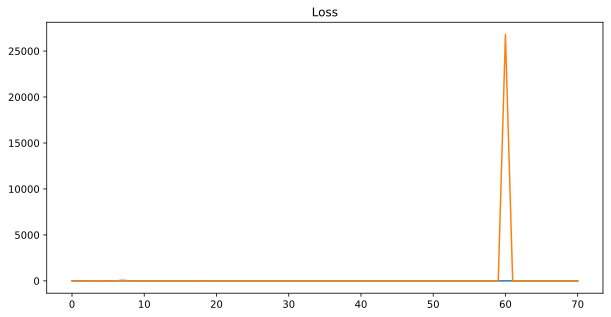

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
#model.load_weights('best_model.hdf5')
#model.save('nn_final.hdf5')

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [ ]:
#бленд для сабмита с катбустом cv
sub_predict_nn3=np.exp(sub_predict_nn3)
blend_sub_predict=(submissions['blend'].values +sub_predict_nn3[:,0])/2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_05.csv', index=False)

In [ ]:
#бленд для сабмита с катбустом cv
blend_sub_predict=0.7*submissions['blend'].values +0.3*sub_predict_nn3[:,0]
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_0703.csv', index=False)

In [ ]:
#оценим ошибку бленда со стандартным катбустом
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(blend_predict)))*100:0.2f}%"